In [9]:
! mkdir ~/.kaggle
! touch ~/.kaggle/kaggle.json

api_token = {"username":"victorkhamesi",
             "key":"1ea0fb67d24bd476918d5e47c401f260"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d giannisgeorgiou/fish-species

! unzip fish-species.zip

In [12]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from shutil import copyfile, rmtree
from pathlib import Path
from glob import glob
import itertools
import warnings
warnings.filterwarnings("ignore")

In [94]:
INPUT_CLASSES_DIR = './Species/Training_Set/'
TRAIN_SAMPLE_SIZE = 300
TEST_SAMPLE_SIZE = 30

folders = glob(INPUT_CLASSES_DIR + '/*')

In [95]:
test_root = './test'
train_root = './train'

rmtree(train_root, ignore_errors=True)
rmtree(test_root, ignore_errors=True)


for dirname in folders:
    if len(os.listdir(dirname)) < TRAIN_SAMPLE_SIZE + TEST_SAMPLE_SIZE:
        print(f'{dirname} contains less files than needed')
        break
    else:
        current_subfolder = dirname.split('/')[-1]
        folder_sample = random.sample(glob(dirname + '/*'), TRAIN_SAMPLE_SIZE + TEST_SAMPLE_SIZE)
        Path(f"{test_root}/{current_subfolder}").mkdir(parents=True, exist_ok=True)
        Path(f"{train_root}/{current_subfolder}").mkdir(parents=True, exist_ok=True)
        train_filenames = folder_sample[:TRAIN_SAMPLE_SIZE]
        for f in train_filenames:
            copyfile(f, f"{train_root}/{current_subfolder}/{f.split('/')[-1]}")
        test_filenames = folder_sample[TRAIN_SAMPLE_SIZE:]
        for f in test_filenames:
            copyfile(f, f"{test_root}/{current_subfolder}/{f.split('/')[-1]}")

In [96]:
train_files = glob(train_root + '/*/*.jp*g')
test_files = glob(test_root + '/*/*.jp*g')

In [97]:
print(len(train_files))
print(len(test_files))

6000
600


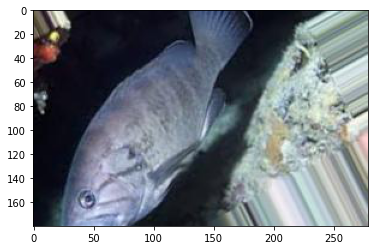

In [98]:
plt.imshow(image.load_img(np.random.choice(train_files)))

In [99]:
IMAGE_SIZE = [200, 200]
epochs = 10
batch_size = 128

In [100]:
# ResNet
res = ResNet50(
input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Weights are not trainable
for layer in res.layers:
  layer.trainable = False

# Chained NN
x = Flatten()(res.output)
prediction = Dense(len(folders), activation='softmax')(x)

# Full model
model = Model(inputs=res.input, outputs=prediction)

model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
  )

In [101]:
train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [102]:
test_gen = val_gen.flow_from_directory(test_root, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 600 images belonging to 20 classes.
{'Anthias anthias': 0, 'Atherinomorus lacunosus': 1, 'Belone belone': 2, 'Boops boops': 3, 'Chlorophthalmus agassizi': 4, 'Coris julis': 5, 'Dasyatis centroura': 6, 'Epinephelus caninus': 7, 'Gobius niger': 8, 'Mugil cephalus': 9, 'Phycis phycis': 10, 'Polyprion americanus': 11, 'Pseudocaranx dentex': 12, 'Rhinobatos cemiculus': 13, 'Scomber japonicus': 14, 'Solea solea': 15, 'Squalus acanthias': 16, 'Tetrapturus belone': 17, 'Trachinus draco': 18, 'Trigloporus lastoviza': 19}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -123.68 max: 151.061


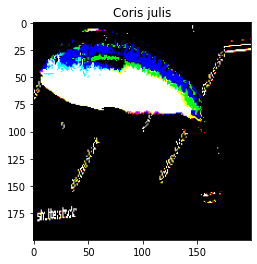

In [105]:
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [106]:
train_generator = train_gen.flow_from_directory(
  train_root,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  test_root,
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 6000 images belonging to 20 classes.
Found 600 images belonging to 20 classes.


In [107]:
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(train_files) // batch_size,
  validation_steps=len(test_files) // batch_size,
)

Epoch 1/10
46/46 [==============================] - 108s 2s/step - loss: 7.2596 - accuracy: 0.1645 - val_loss: 2.3778 - val_accuracy: 0.2266
Epoch 2/10
46/46 [==============================] - 102s 2s/step - loss: 2.0989 - accuracy: 0.3506 - val_loss: 1.8849 - val_accuracy: 0.4336
Epoch 3/10
46/46 [==============================] - 102s 2s/step - loss: 1.5135 - accuracy: 0.5373 - val_loss: 1.4086 - val_accuracy: 0.5430
Epoch 4/10
46/46 [==============================] - 102s 2s/step - loss: 1.2285 - accuracy: 0.6184 - val_loss: 1.2548 - val_accuracy: 0.6094
Epoch 5/10
46/46 [==============================] - 100s 2s/step - loss: 1.0015 - accuracy: 0.6931 - val_loss: 1.1005 - val_accuracy: 0.6816
Epoch 6/10
46/46 [==============================] - 99s 2s/step - loss: 0.8644 - accuracy: 0.7440 - val_loss: 0.8834 - val_accuracy: 0.7363
Epoch 7/10
46/46 [==============================] - 101s 2s/step - loss: 0.7528 - accuracy: 0.7761 - val_loss: 0.7034 - val_accuracy: 0.7969
Epoch 8/10
46/

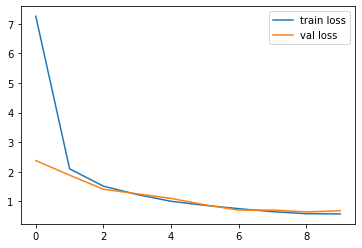

In [109]:
plt.plot(r.history['loss'], label='train loss')
if 'val_loss' in r.history:
    plt.plot(r.history['val_loss'], label='val loss')
plt.legend()

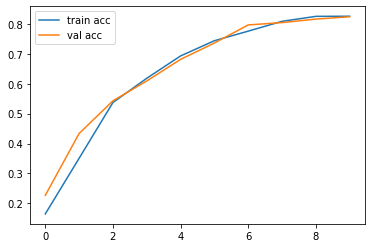

In [110]:
plt.plot(r.history['accuracy'], label='train acc')
if 'val_accuracy' in r.history:
    plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()

In [111]:
model.evaluate(valid_generator)

5/5 [==============================] - 7s 1s/step - loss: 0.6639 - accuracy: 0.8283


[0.6638641953468323, 0.82833331823349]

In [112]:
preds = model.predict(valid_generator)
classes = [x.split('/')[-1] for x in folders]

Predicted: Anthias anthias
Real class: Anthias anthias


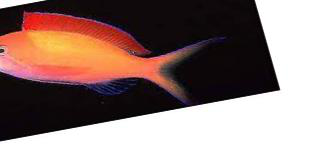

In [117]:
idx = np.random.choice(len(test_files))
samples = np.array(test_files)[idx]
pred_samples = preds[idx]
print("Predicted: " + classes[pred_samples.argmax()])
print("Real class: " + samples.split("/")[2])
image.load_img(samples)